# Estimating COVID-19's $R_t$ with Rainier (ported from PYMC)

Grzegorz Kossakowski & Maciek Zdanowicz - May 5 (beta)

Model originally built by [Kevin Systrom](https://twitter.com/kevin) in `Realtime Rt mcmc.ipynb` notebook, ported to [Rainier](https://rainier.fit) with lots of help from [Avi Bryant](https://twitter.com/avibryant). Model comparison for European countries is in `Realtime Rt plots only.ipynb`.

This notebook requires [Almond](https://almond.sh) to run.

It's a work in progress.

In [35]:
import $ivy.`com.stripe::rainier-core:0.3.3`
import $ivy.`com.stripe::rainier-notebook:0.3.3`

import $ivy.$                               

import $ivy.$                                   

In [36]:
import com.stripe.rainier.compute._
import com.stripe.rainier.core._
import com.stripe.rainier.sampler._
import com.stripe.rainier.notebook._

import com.stripe.rainier.compute._

import com.stripe.rainier.core._

import com.stripe.rainier.sampler._

import com.stripe.rainier.notebook._

In [37]:
PPrint.register(repl)

In [38]:
import $ivy.`com.github.tototoshi::scala-csv:1.3.6`
import com.github.tototoshi.csv._
import java.io.File
import scala.util.Try

import $ivy.$                                      

import com.github.tototoshi.csv._

import java.io.File

import scala.util.Try

In [39]:
def time[R](block: => R): R = {
    val t0 = System.nanoTime()
    val result = block    // call-by-name
    val t1 = System.nanoTime()
    val timeMilis = ((t1 - t0) / 1e6).toInt
    println(s"Elapsed time: $timeMilis ms")
    result
}

defined function time

In [40]:
val countriesOnsetData = {
    val csvReader = CSVReader.open(new File("data/onset.csv"))
    val xs = csvReader.allWithHeaders()
    csvReader.close()
    xs
}

countriesOnsetData: List[Map[String, String]] = List(
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-06",
    "Onset" -> "1.180164888457808"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-07",
    "Onset" -> "1.236663433559651"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-08",
    "Onset" -> "1.6939864209505335"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-09",
    "Onset" -> "1.9956353055286131"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-10",
    "Onset" -> "2.630455868089234"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-11",
    "Onset" -> "2.842386032977692"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-12",
    "Onset" -> "3.0227934044616878"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-13",
...

In [41]:
import java.time.LocalDate
import java.time.chrono.ChronoLocalDate
// so comparisons work like max()
import scala.math.Ordering.Implicits._

def toDate(s: String): LocalDate =
    LocalDate.parse(s)

// we need to specify type parameter ChronoLocalDate (a super type of LocalDate) because
// that's what the comparison is defined for
countriesOnsetData.map(entry => toDate(entry("date"))).max[ChronoLocalDate]

import java.time.LocalDate

import java.time.chrono.ChronoLocalDate
// so comparisons work like max()

import scala.math.Ordering.Implicits._


defined function toDate
res40_4: LocalDate = 2020-08-04

In [42]:
val pdelayData = {
    val csvReader = CSVReader.open(new File("data/pdelay.csv"))
    val xs = csvReader.allWithHeaders()
    csvReader.close()
    xs
}

pdelayData: List[Map[String, String]] = List(
  Map("index" -> "0", "pdelay" -> "0.006547041707080504"),
  Map("index" -> "1", "pdelay" -> "0.04194956353055286"),
  Map("index" -> "2", "pdelay" -> "0.05771096023278371"),
  Map("index" -> "3", "pdelay" -> "0.06983511154219205"),
  Map("index" -> "4", "pdelay" -> "0.07153249272550921"),
  Map("index" -> "5", "pdelay" -> "0.08583899127061105"),
  Map("index" -> "6", "pdelay" -> "0.07953443258971872"),
  Map("index" -> "7", "pdelay" -> "0.07516973811833172"),
  Map("index" -> "8", "pdelay" -> "0.07710960232783705"),
  Map("index" -> "9", "pdelay" -> "0.07904946653734239"),
  Map("index" -> "10", "pdelay" -> "0.06304558680892337"),
  Map("index" -> "11", "pdelay" -> "0.0511639185257032"),
  Map("index" -> "12", "pdelay" -> "0.04485935984481086"),
  Map("index" -> "13", "pdelay" -> "0.038554801163918524"),
  Map("index" -> "14", "pdelay" -> "0.028855480116391854"),
  Map("index" -> "15", "pdelay" -> "0.026430649854510185"),
  Map("index" -> 

In [43]:
val pdelay = pdelayData.collect { case m => m("pdelay").toDouble }

pdelay: List[Double] = List(
  0.006547041707080504,
  0.04194956353055286,
  0.05771096023278371,
  0.06983511154219205,
  0.07153249272550921,
  0.08583899127061105,
  0.07953443258971872,
  0.07516973811833172,
  0.07710960232783705,
  0.07904946653734239,
  0.06304558680892337,
  0.0511639185257032,
  0.04485935984481086,
  0.038554801163918524,
  0.028855480116391854,
  0.026430649854510185,
  0.01915615906886518,
  0.02061105722599418,
  0.011881668283220174,
  0.009456838021338506,
  0.009699321047526674,
  0.006547041707080504,
  0.004122211445198836,
  0.0036372453928225023,
  0.002909796314258002,
  0.0036372453928225023,
  0.0019398642095053346,
  4.8496605237633366E-4,
  4.8496605237633366E-4,
  0.0,
  9.699321047526673E-4,
  2.4248302618816683E-4,
  4.8496605237633366E-4,
  7.274490785645005E-4,
  0.001454898157129001,
  2.4248302618816683E-4,
  4.8496605237633366E-4,
  7.274490785645005E-4,
...

In [44]:
def prepareDataForModel(xs: List[Long], pd: List[Double]): List[(Long,Double)] = {
    val cpd = pd.scanLeft(0.0)(_+_).tail
    val cpdPadded = List.fill(xs.size - pd.size)(1.0) ++ cpd.reverse
    // ensure that case numbers are always at least 1 so we avoid numerical issues involving 0
    // adding 1 across all counts doesn't change inputs in any material way
    // see the comment of `predictRt` method for the rationale
    xs.zip(cpdPadded)
}

defined function prepareDataForModel

Preparation of the other model

In [45]:
val samplerConfig = new DefaultConfig {
    override def massMatrixTuner() = new IdentityMassMatrixTuner
    override def sampler() = new HMCSampler(100)
    override val iterations = 1000
    override val warmupIterations = 1000
}

samplerConfig: DefaultConfig{def massMatrixTuner(): com.stripe.rainier.sampler.IdentityMassMatrixTuner;def sampler(): com.stripe.rainier.sampler.HMCSampler} = ammonite.$sess.cmd44$Helper$$anon$1@15f30c24

Define a function that we'll use to retry the call to Rainier's `predict` that fails occassionally. Fortunately, the failure can be easily detected and 1-2 retries solves the issue.

In [46]:
def argmin[N](seq: Seq[N])(implicit num: Numeric[N]): Int = seq.indexOf(seq.min)

defined function argmin

In [47]:
import scala.collection.mutable.ArrayBuffer

/* Retry returns a value and a list of logs produced during consecutive attempts */
def retry[T](maxAttempts: Int, isSuccessful: T => (Boolean, Double)) (f: => T): (T, List[Double]) = {
    var i = 0
    var flag = false
    val logListBuf = ArrayBuffer.empty[Double]
    val resListBuf = ArrayBuffer.empty[T]
    do {
        i = i + 1
        val res = f
        resListBuf += res
        val (resBool, log) = isSuccessful(res)
        logListBuf += log
        val errorMsg = if(resBool) s"Success in [$i] iteration." else s"WARN: Attempt[$i] failed. Retrying..."
        println(errorMsg)
        flag = resBool
    } while (i < maxAttempts && !flag)
    val logList = logListBuf.toList
    return (resListBuf(argmin(logList)), logList)
}

import scala.collection.mutable.ArrayBuffer

/* Retry returns a value and a list of logs produced during consecutive attempts */

defined function retry

Fixed the parameters for all distributions

In [48]:
case class RtModelEstimates(rts: Vec[Real], 
                            rtsEstimates: List[Seq[Double]], 
                            serialInterval: Real, 
                            serialIntervalEstimates: Seq[Double])

defined class RtModelEstimates

In [48]:
// def predictRtOnsetLogProcess(onsetNumbers: List[Long], pdelay: List[Double]): (Vec[Real], List[Seq[Double]]) = {
    
//     val data = prepareDataForModel(onsetNumbers, pdelay)
    
//     val (model, rts) =  {
//         val (onset, cum_pdelay) = data.unzip
//         val serialInterval = Gamma(46.0,10.0).latent
//         val logR0 = Normal(0, 1).latent
//         val sigma = Exponential(10).latent
//         val diffs = Laplace(0,sigma).latentVec(data.size)
//         val logRts = Vec.from(diffs.toList.scanLeft(logR0)(_ + _))
//         val inferredYesterday = data.take(data.size-1).map { case (o_t, cp_t) => 
//             o_t/cp_t 
//         }.zipWithIndex
//         val expectedToday = Vec.from(inferredYesterday.zip(cum_pdelay.drop(1))).map { case ((infYest, i), cpd) =>
//             val lambda = infYest*cpd*((logRts(i).exp - 1)/serialInterval).exp
//             Poisson(lambda)
//         }
//         (Model.observe(onset.drop(1), expectedToday), logRts.map(_.exp))
//     }
    
//     def detectFailedRun(trace: Trace): (Boolean, Double) = {
//         // from: https://twitter.com/avibryant/status/1253049509128499201
//         val stat = trace.diagnostics.map(_.rHat).max
//         (stat < 1.1, stat)
//     }
    
//     val (trace, log) = retry(maxAttempts = 10, isSuccessful = detectFailedRun) {
//         model.sample(samplerConfig, 4)
//     }
    
//     rts -> trace.predict(rts)
// }

In [55]:
// direct (and faithful) translation of Systrom's MCMC model from
// Realtime Rt mcmc.ipynb up to different handling of this line
// mu = pm.math.maximum(.1, expected_today)
// my is the lambda of Poisson distribution that must be > 0.
// Kevin's solution is to take max(0.1, expected_today) to ensure
// that lambda > 0. However, `expected_today` is dependent only on input data and is not
// part of the model so we can ensure it's > 0 by fixing up the input data of the model.
// this is done in `prepareDataForModel`
def predictRt(onsetNumbers: List[Long], pdelay: List[Double], failedRunDetection: Boolean = true): (RtModelEstimates, List[Double]) = {
    
    val data = prepareDataForModel(onsetNumbers, pdelay)
    
    val (model, rts, serialInterval) = {
        val (onset, cum_pdelay) = data.unzip
        val serialInterval = Gamma(6.0,1/1.5).latent
        val sigma = Normal(0,0.03).latent.abs
        val Theta0 = Normal(0.1,0.1).latent
        val diffs = Laplace(0,sigma).latentVec(data.size) // Maybe normal would be better
        val ThetaT = Vec.from(diffs.toList.scanLeft(Theta0)(_ + _))
        val Rts = ThetaT.map(_*serialInterval + 1)
        val inferredYesterday = data.take(data.size-1).map { case (o_t, cp_t) => 
            o_t/cp_t 
        }.zipWithIndex
        val expectedToday = Vec.from(inferredYesterday.zip(cum_pdelay.drop(1))).map { case ((infYest, i), cpd) =>
            val lambda = Real(0.1).max(infYest * cpd * (ThetaT(i).exp))
            Poisson(lambda)
        }
        
        val obsModel = Model.observe(onset.drop(1), expectedToday)
        val trackSerialInterval = Model.track(Set(serialInterval))
        (obsModel.merge(trackSerialInterval), Rts, serialInterval)
    }
    
    def detectFailedRun(trace: Trace): (Boolean, Double) = {
        // from: https://twitter.com/avibryant/status/1253049509128499201
        val stat = trace.diagnostics.map(_.rHat).max
        val cond = !failedRunDetection || stat < 1.1
        (cond, stat)
    }
    
    val (trace, log) = retry(maxAttempts = 5, isSuccessful = detectFailedRun) {
        model.sample(samplerConfig, 2)
    }

    val rtme = RtModelEstimates(rts = rts, 
                 rtsEstimates = trace.predict(rts),
                 serialInterval = serialInterval,
                 serialIntervalEstimates = trace.predict(serialInterval))
    (rtme, log)
}

defined function predictRt

In [56]:
def median[N](seq: Seq[N])(implicit num: Numeric[N]): Double = {
    val l = (seq.map { n =>
      num.toDouble(n)
    }).sorted
    val n = l.size
    if(n % 2 == 1)
        l(n/2)
    else
        (l(n/2) + l(n/2-1))/2
}

defined function median

In [57]:
case class RtsDistributionStats(means: Seq[(Int, Double)], 
                                medians: Seq[(Int, Double)],
                                hdpis_90: Seq[(Int, (Double, Double))], 
                                hdpis_50: Seq[(Int, (Double, Double))])
def distributionStats(rts: Vec[Real], rtForecasts: List[Seq[Double]]): RtsDistributionStats = {
    val means = 0.until(rts.size).map{i => (i,mean(rtForecasts.map(_(i))))}
    val medians = 0.until(rts.size).map{i => (i,median(rtForecasts.map(_(i))))}
    val hdpis_90 = 0.until(rts.size).map{i => (i,hdpi(rtForecasts.map(_(i)),0.9))}
    val hdpis_50 = 0.until(rts.size).map{i => (i,hdpi(rtForecasts.map(_(i)),0.5))}
    RtsDistributionStats(means, medians, hdpis_90, hdpis_50)
}

defined class RtsDistributionStats
defined function distributionStats

In [59]:
val countryLogs = scala.collection.mutable.Map[String, List[Double]]()

def processLogs(country: String, logs: List[Double]) = {
    countryLogs(country) = logs
}

countryLogs: collection.mutable.Map[String, List[Double]] = Map()
defined function processLogs

In [59]:
// {{
//     val countryName = "United_Kingdom"
//     val onsetNumbers = countriesOnsetData.collect {
//         case m if m("country") == countryName => m("Onset").toDouble.round
//     }
//     val RtModelEstimates(rts,estimates,_, _) = time { 
//         val (res, log) = predictRt(onsetNumbers, pdelay, failedRunDetection = true)
//         processLogs(countryName, log)
//         res
//     }
//     val RtsDistributionStats(means, medians, hdpis_90, hdpis_50) = distributionStats(rts, estimates)
//     // show("t", "Rt", line(means), shade(hdpis_50))
//     show("t", "Rt", line(means), shade(hdpis_90))
// }}

In [60]:
// val countriesToPredict = Seq("Poland", "France", "Italy") // Smaller set
val countriesToPredict = countriesOnsetData.map(_("country")).toSet  // Full set

countriesToPredict: Set[String] = Set(
  "Poland",
  "Croatia",
  "Luxembourg",
  "Greece",
  "Spain",
  "Russia",
  "Estonia",
  "Czechia",
  "Romania",
  "Denmark",
  "Belgium",
  "Slovenia",
  "Malta",
  "Belarus",
  "Slovakia",
  "Finland",
  "Lithuania",
  "Sweden",
  "United_Kingdom",
  "Austria",
  "Latvia",
  "Italy",
  "Ireland",
  "Bulgaria",
  "Norway",
  "France",
  "Netherlands",
  "Switzerland",
  "Cyprus",
  "Germany",
  "Portugal",
  "Hungary"
)

In [61]:
val countryStats: Map[String, Either[Throwable, RtsDistributionStats]] = {
    assert(countriesToPredict.toSet.subsetOf(countriesOnsetData.map(_("country")).toSet))
    val allStats = time {
        countriesToPredict.par.map { countryName =>
            val caseNumbers = countriesOnsetData.collect {
                case m if m("country") == countryName => m("Onset").toDouble.round
            }
            val possiblyFailed: Try[RtsDistributionStats] = Try { 
                val (rtme, logs) = predictRt(caseNumbers, pdelay, failedRunDetection = true)
                processLogs(countryName, logs)
                val RtModelEstimates(rts,estimates, serialInterval, serialEstimates) = rtme
                val stats@RtsDistributionStats(means, medians, hdpis_90, hdpis_50) = distributionStats(rts, estimates)
                println(s"$countryName [done]")
                stats
            }
            countryName -> possiblyFailed.toEither
        }.seq
    }
    allStats.toMap
}

Chain 1 Complete : Iteration: 1000 (96ms) Acceptance rate: 0.79 E-BFMI: 0.64 Step size: 0.03 Total gradient evaluations: 2e+05 (477us) Total time: 0: 3:19

Chain 1 Complete : Iteration: 1000 (129ms) Acceptance rate: 0.74 E-BFMI: 0.72 Step size: 0.03 Total gradient evaluations: 2e+05 (638us) Total time: 0: 4:25

Chain 1 Complete : Iteration: 1000 (220ms) Acceptance rate: 0.82 E-BFMI: 0.76 Step size: 0.009 Total gradient evaluations: 2e+05 (1ms) Total time: 0: 7:23

Chain 1 Complete : Iteration: 1000 (324ms) Acceptance rate: 0.85 E-BFMI: 0.58 Step size: 0.004 Total gradient evaluations: 2e+05 (1ms) Total time: 0:10:51

Chain 2 Complete : Iteration: 1000 (94ms) Acceptance rate: 0.85 E-BFMI: 0.70 Step size: 0.03 Total gradient evaluations: 2e+05 (466us) Total time: 0: 3:14

Chain 2 Complete : Iteration: 1000 (127ms) Acceptance rate: 0.81 E-BFMI: 0.64 Step size: 0.03 Total gradient evaluations: 2e+05 (624us) Total time: 0: 4:17

Success in [1] iteration.
Slovakia [done]


Chain 1 Complete : Iteration: 1000 (190ms) Acceptance rate: 0.78 E-BFMI: 0.79 Step size: 0.03 Total gradient evaluations: 2e+05 (969us) Total time: 0: 6:23

Chain 2 Complete : Iteration: 1000 (219ms) Acceptance rate: 0.81 E-BFMI: 0.60 Step size: 0.009 Total gradient evaluations: 2e+05 (1ms) Total time: 0: 7:18

WARN: Attempt[1] failed. Retrying...
Luxembourg [done]


Chain 1 Complete : Iteration: 1000 (126ms) Acceptance rate: 0.81 E-BFMI: 0.72 Step size: 0.03 Total gradient evaluations: 2e+05 (628us) Total time: 0: 4:20

Chain 2 Complete : Iteration: 1000 (323ms) Acceptance rate: 0.83 E-BFMI: 0.98 Step size: 0.004 Total gradient evaluations: 2e+05 (1ms) Total time: 0:10:46

Chain 2 Complete : Iteration: 1000 (188ms) Acceptance rate: 0.78 E-BFMI: 0.69 Step size: 0.02 Total gradient evaluations: 2e+05 (928us) Total time: 0: 6:20

Chain 2 Complete : Iteration: 1000 (127ms) Acceptance rate: 0.81 E-BFMI: 0.65 Step size: 0.03 Total gradient evaluations: 2e+05 (632us) Total time: 0: 4:17

WARN: Attempt[1] failed. Retrying...
Portugal [done]


Chain 1 Complete : Iteration: 1000 (110ms) Acceptance rate: 0.78 E-BFMI: 0.67 Step size: 0.03 Total gradient evaluations: 2e+05 (546us) Total time: 0: 3:45

Success in [1] iteration.
Greece [done]


Chain 1 Complete : Iteration: 1000 (133ms) Acceptance rate: 0.88 E-BFMI: 0.65 Step size: 0.02 Total gradient evaluations: 2e+05 (652us) Total time: 0: 4:30

Chain 2 Complete : Iteration: 1000 (113ms) Acceptance rate: 0.84 E-BFMI: 0.60 Step size: 0.03 Total gradient evaluations: 2e+05 (578us) Total time: 0: 3:46

Success in [1] iteration.
Finland [done]


Chain 1 Complete : Iteration: 1000 (155ms) Acceptance rate: 0.86 E-BFMI: 0.66 Step size: 0.006 Total gradient evaluations: 2e+05 (770us) Total time: 0: 5:19

WARN: Attempt[1] failed. Retrying...
Spain [done]


Chain 1 Complete : Iteration: 1000 (143ms) Acceptance rate: 0.87 E-BFMI: 0.66 Step size: 0.001 Total gradient evaluations: 2e+05 (657us) Total time: 0: 4:49

Chain 2 Complete : Iteration: 1000 (133ms) Acceptance rate: 0.78 E-BFMI: 0.68 Step size: 0.03 Total gradient evaluations: 2e+05 (658us) Total time: 0: 4:30

WARN: Attempt[1] failed. Retrying...
Hungary [done]


Chain 1 Complete : Iteration: 1000 (120ms) Acceptance rate: 0.80 E-BFMI: 0.67 Step size: 0.03 Total gradient evaluations: 2e+05 (587us) Total time: 0: 4: 8

Chain 2 Complete : Iteration: 1000 (157ms) Acceptance rate: 0.85 E-BFMI: 0.51 Step size: 0.006 Total gradient evaluations: 2e+05 (776us) Total time: 0: 5:17

Chain 2 Complete : Iteration: 1000 (120ms) Acceptance rate: 0.81 E-BFMI: 0.62 Step size: 0.03 Total gradient evaluations: 2e+05 (589us) Total time: 0: 4: 2

Success in [1] iteration.


Chain 2 Complete : Iteration: 1000 (146ms) Acceptance rate: 0.97 E-BFMI: 1.00 Step size: 0.002 Total gradient evaluations: 2e+05 (723us) Total time: 0: 4:47

Croatia [done]


Chain 1 Complete : Iteration: 1000 (126ms) Acceptance rate: 0.89 E-BFMI: 0.70 Step size: 0.009 Total gradient evaluations: 2e+05 (698us) Total time: 0: 4: 6

Success in [1] iteration.
Belarus [done]


Chain 1 Complete : Iteration: 1000 (67ms) Acceptance rate: 0.80 E-BFMI: 0.68 Step size: 0.03 Total gradient evaluations: 2e+05 (330us) Total time: 0: 3:14

Success in [1] iteration.
Cyprus [done]


Chain 1 Complete : Iteration: 1000 (201ms) Acceptance rate: 0.92 E-BFMI: 0.58 Step size: 0.004 Total gradient evaluations: 2e+05 (979us) Total time: 0: 6:40

Chain 2 Complete : Iteration: 1000 (121ms) Acceptance rate: 0.82 E-BFMI: 0.53 Step size: 0.01 Total gradient evaluations: 2e+05 (600us) Total time: 0: 3:22

WARN: Attempt[1] failed. Retrying...
Russia [done]


Chain 2 Complete : Iteration: 1000 (119ms) Acceptance rate: 0.84 E-BFMI: 0.63 Step size: 0.03 Total gradient evaluations: 2e+05 (600us) Total time: 0: 3:27

WARN: Attempt[1] failed. Retrying...
Poland [done]


Chain 1 Complete : Iteration: 1000 (164ms) Acceptance rate: 0.77 E-BFMI: 0.63 Step size: 0.009 Total gradient evaluations: 2e+05 (806us) Total time: 0: 5:28

Chain 1 Complete : Iteration: 1000 (222ms) Acceptance rate: 0.89 E-BFMI: 0.64 Step size: 0.003 Total gradient evaluations: 2e+05 (1ms) Total time: 0: 7:27

Success in [1] iteration.
Estonia [done]


Chain 1 Complete : Iteration: 1000 (136ms) Acceptance rate: 0.87 E-BFMI: 0.63 Step size: 0.02 Total gradient evaluations: 2e+05 (676us) Total time: 0: 4:34

Chain 2 Complete : Iteration: 1000 (197ms) Acceptance rate: 0.75 E-BFMI: 0.66 Step size: 0.005 Total gradient evaluations: 2e+05 (977us) Total time: 0: 6:38

Chain 2 Complete : Iteration: 1000 (159ms) Acceptance rate: 0.86 E-BFMI: 0.70 Step size: 0.009 Total gradient evaluations: 2e+05 (788us) Total time: 0: 5:26

Chain 2 Complete : Iteration: 1000 (136ms) Acceptance rate: 0.67 E-BFMI: 0.65 Step size: 0.02 Total gradient evaluations: 2e+05 (670us) Total time: 0: 4:34

Chain 2 Complete : Iteration: 1000 (221ms) Acceptance rate: 0.87 E-BFMI: 0.69 Step size: 0.003 Total gradient evaluations: 2e+05 (1ms) Total time: 0: 7:24

WARN: Attempt[1] failed. Retrying...
Germany [done]


Chain 1 Complete : Iteration: 1000 (167ms) Acceptance rate: 0.87 E-BFMI: 0.68 Step size: 0.01 Total gradient evaluations: 2e+05 (823us) Total time: 0: 5:40

WARN: Attempt[1] failed. Retrying...
Netherlands [done]


Chain 1 Complete : Iteration: 1000 (103ms) Acceptance rate: 0.87 E-BFMI: 0.66 Step size: 0.02 Total gradient evaluations: 2e+05 (518us) Total time: 0: 3:34

Success in [1] iteration.
Czechia [done]


Chain 1 Complete : Iteration: 1000 (125ms) Acceptance rate: 0.85 E-BFMI: 0.69 Step size: 0.01 Total gradient evaluations: 2e+05 (602us) Total time: 0: 4:10

Chain 2 Complete : Iteration: 1000 (105ms) Acceptance rate: 0.86 E-BFMI: 0.64 Step size: 0.01 Total gradient evaluations: 2e+05 (513us) Total time: 0: 3:31

WARN: Attempt[1] failed. Retrying...
Italy [done]


Chain 1 Complete : Iteration: 1000 (137ms) Acceptance rate: 0.89 E-BFMI: 0.68 Step size: 0.01 Total gradient evaluations: 2e+05 (678us) Total time: 0: 4:36

Chain 2 Complete : Iteration: 1000 (166ms) Acceptance rate: 0.86 E-BFMI: 0.68 Step size: 0.01 Total gradient evaluations: 2e+05 (835us) Total time: 0: 5:36

Chain 2 Complete : Iteration: 1000 (124ms) Acceptance rate: 0.53 E-BFMI: 0.65 Step size: 0.01 Total gradient evaluations: 2e+05 (603us) Total time: 0: 4: 8

Success in [1] iteration.
Bulgaria [done]


Chain 1 Complete : Iteration: 1000 (144ms) Acceptance rate: 0.88 E-BFMI: 0.70 Step size: 0.02 Total gradient evaluations: 2e+05 (706us) Total time: 0: 4:53

Chain 2 Complete : Iteration: 1000 (136ms) Acceptance rate: 0.79 E-BFMI: 0.70 Step size: 0.01 Total gradient evaluations: 2e+05 (677us) Total time: 0: 4:37

Success in [1] iteration.
Romania [done]


Chain 1 Complete : Iteration: 1000 (154ms) Acceptance rate: 0.84 E-BFMI: 0.65 Step size: 0.02 Total gradient evaluations: 2e+05 (789us) Total time: 0: 5:12

WARN: Attempt[1] failed. Retrying...
Switzerland [done]


Chain 1 Complete : Iteration: 1000 (274ms) Acceptance rate: 0.84 E-BFMI: 0.65 Step size: 0.003 Total gradient evaluations: 2e+05 (1ms) Total time: 0: 9: 8

Chain 2 Complete : Iteration: 1000 (144ms) Acceptance rate: 0.85 E-BFMI: 0.71 Step size: 0.02 Total gradient evaluations: 2e+05 (712us) Total time: 0: 4:50

Success in [1] iteration.
Ireland [done]


Chain 1 Complete : Iteration: 1000 (121ms) Acceptance rate: 0.79 E-BFMI: 0.59 Step size: 0.03 Total gradient evaluations: 2e+05 (585us) Total time: 0: 4: 0

Chain 2 Complete : Iteration: 1000 (150ms) Acceptance rate: 0.85 E-BFMI: 0.72 Step size: 0.02 Total gradient evaluations: 2e+05 (745us) Total time: 0: 5: 8

WARN: Attempt[1] failed. Retrying...
Norway [done]


Chain 1 Complete : Iteration: 1000 (186ms) Acceptance rate: 0.78 E-BFMI: 0.59 Step size: 0.005 Total gradient evaluations: 2e+05 (926us) Total time: 0: 6:19

Chain 2 Complete : Iteration: 1000 (116ms) Acceptance rate: 0.84 E-BFMI: 0.69 Step size: 0.03 Total gradient evaluations: 2e+05 (579us) Total time: 0: 3:58

Chain 2 Complete : Iteration: 1000 (274ms) Acceptance rate: 0.85 E-BFMI: 0.80 Step size: 0.003 Total gradient evaluations: 2e+05 (1ms) Total time: 0: 9:11

WARN: Attempt[1] failed. Retrying...
Denmark [done]


Chain 1 Complete : Iteration: 1000 (239ms) Acceptance rate: 0.86 E-BFMI: 0.69 Step size: 0.009 Total gradient evaluations: 2e+05 (1ms) Total time: 0: 7:58

Success in [1] iteration.
Latvia [done]


Chain 1 Complete : Iteration: 1000 (116ms) Acceptance rate: 0.76 E-BFMI: 0.65 Step size: 0.03 Total gradient evaluations: 2e+05 (569us) Total time: 0: 3:55

Chain 2 Complete : Iteration: 1000 (193ms) Acceptance rate: 0.87 E-BFMI: 0.86 Step size: 0.004 Total gradient evaluations: 2e+05 (938us) Total time: 0: 6:16

Chain 2 Complete : Iteration: 1000 (119ms) Acceptance rate: 0.80 E-BFMI: 0.65 Step size: 0.03 Total gradient evaluations: 2e+05 (581us) Total time: 0: 3:56

Chain 2 Complete : Iteration: 1000 (154ms) Acceptance rate: 0.84 E-BFMI: 0.67 Step size: 0.008 Total gradient evaluations: 2e+05 (764us) Total time: 0: 5:52

WARN: Attempt[1] failed. Retrying...
United_Kingdom [done]


Chain 1 Complete : Iteration: 1000 (146ms) Acceptance rate: 0.79 E-BFMI: 0.70 Step size: 0.02 Total gradient evaluations: 2e+05 (723us) Total time: 0: 4:55

Success in [1] iteration.
Lithuania [done]


Chain 1 Complete : Iteration: 1000 (139ms) Acceptance rate: 0.87 E-BFMI: 0.60 Step size: 0.008 Total gradient evaluations: 2e+05 (689us) Total time: 0: 4:44

WARN: Attempt[1] failed. Retrying...
France [done]
WARN: Attempt[1] failed. Retrying...


Chain 2 Complete : Iteration: 1000 (146ms) Acceptance rate: 0.84 E-BFMI: 0.70 Step size: 0.02 Total gradient evaluations: 2e+05 (724us) Total time: 0: 4:49

Belgium [done]


Chain 1 Complete : Iteration: 1000 (76ms) Acceptance rate: 0.83 E-BFMI: 0.65 Step size: 0.03 Total gradient evaluations: 2e+05 (371us) Total time: 0: 2:34

Chain 2 Complete : Iteration: 1000 (80ms) Acceptance rate: 0.81 E-BFMI: 0.75 Step size: 0.007 Total gradient evaluations: 2e+05 (398us) Total time: 0: 4:32

Chain 2 Complete : Iteration: 1000 (75ms) Acceptance rate: 0.76 E-BFMI: 0.70 Step size: 0.03 Total gradient evaluations: 2e+05 (371us) Total time: 0: 2:33

Success in [1] iteration.
Austria [done]
WARN: Attempt[1] failed. Retrying...
Sweden [done]
Success in [1] iteration.
Slovenia [done]


Chain 1 Complete : Iteration: 1000 (62ms) Acceptance rate: 0.82 E-BFMI: 0.67 Step size: 0.03 Total gradient evaluations: 2e+05 (307us) Total time: 0: 2: 6

Chain 2 Complete : Iteration: 1000 (62ms) Acceptance rate: 0.80 E-BFMI: 0.64 Step size: 0.03 Total gradient evaluations: 2e+05 (309us) Total time: 0: 2: 5

Success in [1] iteration.
Malta [done]
Elapsed time: 5334718 ms


countryStats: Map[String, Either[Throwable, RtsDistributionStats]] = Map(
  "Poland" -> Right(
    RtsDistributionStats(
      Vector(
        (0, 1.3802825206895601),
        (1, 1.3774874587409933),
        (2, 1.380648296809943),
        (3, 1.3831166383025597),
        (4, 1.3808539543564176),
        (5, 1.3812417934365686),
        (6, 1.379719113874129),
        (7, 1.3774503643063665),
        (8, 1.38039173404507),
        (9, 1.380014085241823),
        (10, 1.3787679276409575),
        (11, 1.3811771934750947),
        (12, 1.3831607203310234),
        (13, 1.3811703569460683),
        (14, 1.3822069313822494),
        (15, 1.3764058459694672),
        (16, 1.3759153683981886),
        (17, 1.378093385338726),
        (18, 1.3765211317452493),
        (19, 1.3749542039392084),
        (20, 1.3759137137625932),
        (21, 1.365792586843804),
        (22, 1.3602109370629745),
        (23, 1.3497814468004117),
        (24, 1.3453700839966778),
        (25, 1.3408708208181945)

In [62]:
countryStats("Italy")

res61: Either[Throwable, RtsDistributionStats] = Right(
  RtsDistributionStats(
    Vector(
      (0, 1.6290799119070427),
      (1, 1.6295275421977948),
      (2, 1.6450728859513803),
      (3, 1.6444478602453896),
      (4, 1.6517700806805933),
      (5, 1.6514977394425696),
      (6, 1.6549050785925596),
      (7, 1.6771779012794161),
      (8, 1.6774471397256632),
      (9, 1.6796091599311809),
      (10, 1.6849440343242732),
      (11, 1.6759678340965498),
      (12, 1.6848681022195435),
      (13, 1.6849513963741525),
      (14, 1.6894605748666978),
      (15, 1.6742749689597567),
      (16, 1.6848538139494615),
      (17, 1.6846500518078147),
      (18, 1.6778715842788392),
      (19, 1.6787538821303),
      (20, 1.6824828460201384),
      (21, 1.67459102084976),
      (22, 1.6731243712183785),
      (23, 1.6588145875135822),
      (24, 1.6613643994892375),
      (25, 1.6551338907898623),
      (26, 1.6517297339113712),
      (27, 1.645752460033108),
      (28, 1.640608290952825

In [62]:
// val failedToConverge = countryStats collect {
//     case (countryName, res) if res.isLeft => countryName
// } 

In [62]:
// val countriesTriedOneMoreTime = failedToConverge.toSeq map { countryName =>
//     println(countryName)
//     val onsetNumbers = countriesOnsetData.collect {
//         case m if m("country") == countryName => m("Onset").toDouble.round
//     }
//     val RtModelEstimates(rts, estimates, serialInterval, serialEstimates) = time { 
//         val (res, logs) = predictRt(onsetNumbers, pdelay, failedRunDetection = false)
//         processLogs(countryName, logs)
//         res
//     }
//     countryName -> distributionStats(rts, estimates)
// }

In [63]:
val finalCountryStats = (countryStats collect {
    case (countryName, Right(stats)) => countryName -> stats
})// ++ countriesTriedOneMoreTime

finalCountryStats: Map[String, RtsDistributionStats] = Map(
  "Poland" -> RtsDistributionStats(
    Vector(
      (0, 1.3802825206895601),
      (1, 1.3774874587409933),
      (2, 1.380648296809943),
      (3, 1.3831166383025597),
      (4, 1.3808539543564176),
      (5, 1.3812417934365686),
      (6, 1.379719113874129),
      (7, 1.3774503643063665),
      (8, 1.38039173404507),
      (9, 1.380014085241823),
      (10, 1.3787679276409575),
      (11, 1.3811771934750947),
      (12, 1.3831607203310234),
      (13, 1.3811703569460683),
      (14, 1.3822069313822494),
      (15, 1.3764058459694672),
      (16, 1.3759153683981886),
      (17, 1.378093385338726),
      (18, 1.3765211317452493),
      (19, 1.3749542039392084),
      (20, 1.3759137137625932),
      (21, 1.365792586843804),
      (22, 1.3602109370629745),
      (23, 1.3497814468004117),
      (24, 1.3453700839966778),
      (25, 1.3408708208181945),
      (26, 1.3319265903216573),
      (27, 1.32001956835623),
      (28, 1.30

In [64]:
// override the previous variable so the rest of the notebook works fine
val countryStats = finalCountryStats

countryStats: Map[String, RtsDistributionStats] = Map(
  "Poland" -> RtsDistributionStats(
    Vector(
      (0, 1.3802825206895601),
      (1, 1.3774874587409933),
      (2, 1.380648296809943),
      (3, 1.3831166383025597),
      (4, 1.3808539543564176),
      (5, 1.3812417934365686),
      (6, 1.379719113874129),
      (7, 1.3774503643063665),
      (8, 1.38039173404507),
      (9, 1.380014085241823),
      (10, 1.3787679276409575),
      (11, 1.3811771934750947),
      (12, 1.3831607203310234),
      (13, 1.3811703569460683),
      (14, 1.3822069313822494),
      (15, 1.3764058459694672),
      (16, 1.3759153683981886),
      (17, 1.378093385338726),
      (18, 1.3765211317452493),
      (19, 1.3749542039392084),
      (20, 1.3759137137625932),
      (21, 1.365792586843804),
      (22, 1.3602109370629745),
      (23, 1.3497814468004117),
      (24, 1.3453700839966778),
      (25, 1.3408708208181945),
      (26, 1.3319265903216573),
      (27, 1.32001956835623),
      (28, 1.3075148

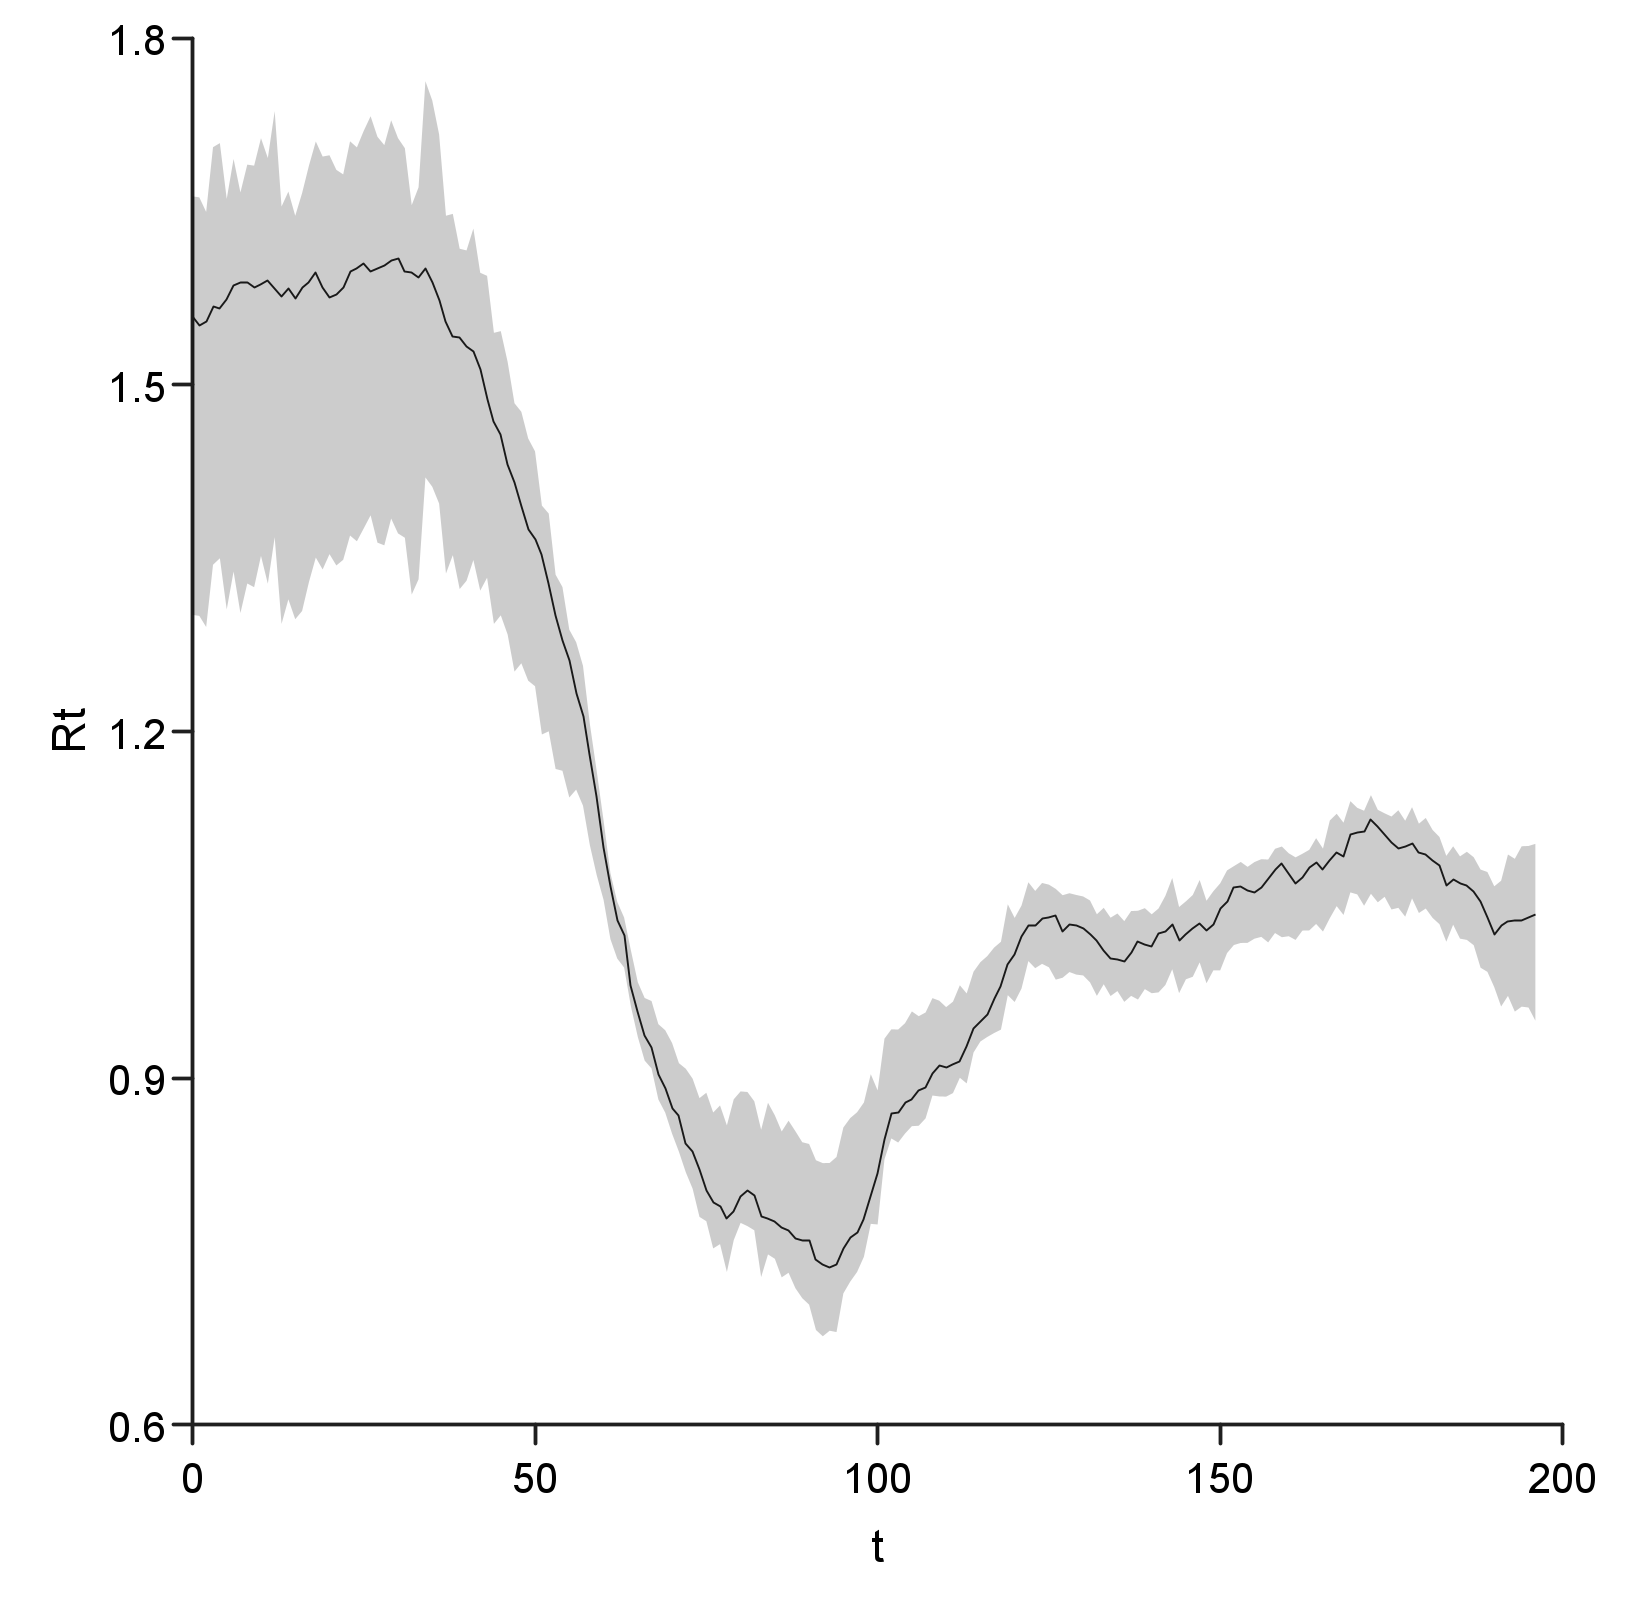

In [65]:
{{
    val RtsDistributionStats(means, medians, hdpis_90, hdpis_50) = countryStats("France")
    show("t", "Rt", line(medians), shade(hdpis_50))
}}

## Saving the results

In [66]:
def datesForCountry(country: String) = {
    countriesOnsetData.collect {
        case m if m("country") == country => m("date")
    }
}

defined function datesForCountry

In [67]:
def writeStatsToCsv(country: String, stats: RtsDistributionStats, csvWriter: CSVWriter): Unit = {
    val means_medians = stats.means.unzip._2 zip stats.medians.unzip._2
    val hdpis = stats.hdpis_90.unzip._2 zip stats.hdpis_50.unzip._2
    val xs = means_medians zip hdpis
    val dates = datesForCountry(country)
//     assert(xs.size == dates.size, s"${xs.size} != ${dates.size}")
    (xs zip dates) foreach {
        case (((mean, median),((low90,high90),(low50,high50))), date) => 
            csvWriter.writeRow(country :: date :: mean.toString :: median.toString :: low90.toString :: high90.toString 
                               :: low50.toString :: high50.toString :: Nil)
    }
}

defined function writeStatsToCsv

In [68]:
val csvWriter = CSVWriter.open(new File("data/rt-rainier.csv"))

csvWriter: CSVWriter = com.github.tototoshi.csv.CSVWriter@57633e9c

In [69]:
csvWriter.writeRow(List("region", "date", "mean", "median", "lower_90", "upper_90", "lower_50", "upper_50"))

In [70]:
countryStats.toList.sortBy(_._1).foreach {
    case (country, stats) => writeStatsToCsv(country, stats, csvWriter)
}

In [71]:
csvWriter.close()

## Processing logs

In [72]:
val csvData = {
    val csvReader = CSVReader.open(new File("data/rhats.csv"))
    val data = csvReader.allWithHeaders()
    csvReader.close()
    data
}

csvData: List[Map[String, String]] = List(
  Map(
    "country" -> "France",
    "idx" -> "0",
    "iteration" -> "0",
    "rhat" -> "9.825113145264448"
  ),
  Map(
    "country" -> "France",
    "idx" -> "0",
    "iteration" -> "1",
    "rhat" -> "1.217108267885155"
  ),
  Map(
    "country" -> "Italy",
    "idx" -> "0",
    "iteration" -> "0",
    "rhat" -> "8.641934743051355"
  ),
  Map(
    "country" -> "Italy",
    "idx" -> "0",
    "iteration" -> "1",
    "rhat" -> "1.3510000716847785"
  ),
  Map(
    "country" -> "Poland",
    "idx" -> "0",
    "iteration" -> "0",
    "rhat" -> "4.770485100025337"
  ),
  Map(
    "country" -> "Poland",
    "idx" -> "0",
    "iteration" -> "1",
    "rhat" -> "5.037074563060128"
  )
)

In [73]:
def writeCountryLogs(writer: CSVWriter, country: String) = {
    val countryData = csvData filter (_("country") == country)
    val countryMaxIdx = if (countryData.isEmpty) 0 else (countryData collect { case m => m("idx").toInt}).max + 1
    val additionalData = countryLogs(country).zipWithIndex.map {
        case (value,i) => Map("country" -> country, "idx" -> countryMaxIdx.toString, 
                              "iteration" -> i.toString, "rhat" -> value.toString)
    }
    val allData = countryData ++ additionalData
    for(elem <- allData) {
        writer.writeRow(country :: elem("idx") :: elem("iteration") :: elem("rhat") :: Nil)
    }
}

val countriesInCsv = (csvData collect { case m => m("country")}).toSet
val countriesInLogs = countryLogs.keys.toSet
val allCountries = (countriesInCsv ++ countriesInLogs).toList.sorted
val csvLogsWriter = CSVWriter.open(new File("data/rhats.csv"))
csvLogsWriter.writeRow(List("country", "idx", "iteration", "rhat"))
allCountries.foreach(writeCountryLogs(csvLogsWriter, _))
csvLogsWriter.close()

defined function writeCountryLogs
countriesInCsv: Set[String] = Set("France", "Italy", "Poland")
countriesInLogs: Set[String] = Set(
  "Poland",
  "Croatia",
  "Luxembourg",
  "Greece",
  "Spain",
  "Russia",
  "Estonia",
  "Czechia",
  "Romania",
  "Denmark",
  "Belgium",
  "Slovenia",
  "Malta",
  "Belarus",
  "Slovakia",
  "Finland",
  "Lithuania",
  "Sweden",
  "United_Kingdom",
  "Austria",
  "Latvia",
  "Italy",
  "Ireland",
  "Bulgaria",
  "Norway",
  "France",
  "Netherlands",
  "Switzerland",
  "Cyprus",
  "Germany",
  "Portugal",
  "Hungary"
)
allCountries: List[String] = List(
  "Austria",
  "Belarus",
  "Belgium",
  "Bulgaria",
  "Croatia",
  "Cyprus",
  "Czechia",
  "Denmark",
  "Estonia",
  "Finland",
  "France",
  "Germany",
  "Greece",
  "Hungary",
  "Ireland",
  "Italy",
  "Latvia",
  "Lithuania",
  "Luxembourg",
  "Malta",
  "Netherlands",
  "Norway",
  "Poland",
  "Portugal",
  "Romania",
  "Russia",
  "Slovakia",
  "Slovenia",
  "Spain",
  "Sweden",
  "Switzerland",